In [ ]:
!pip install wikidata-dl
!pip install pandas SPARQLWrapper requests

In [1]:
import os
import json
import ast

import math
import time
import re
import sys
import logging
from typing import Dict, List, Optional, Tuple
from dataclasses import dataclass
from SPARQLWrapper import SPARQLWrapper, JSON
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import pickle
import psutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
import random

from typing import List, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)
random.seed(42)
torch.backends.cudnn.deterministic = True

2026-02-05 23:14:41.505297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770333282.678451 3708023 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770333282.971604 3708023 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-05 23:14:45.116187: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_preprocessed = pd.read_csv('data/df_preprocessed.csv')
df_preprocessed

,article_id,theme,concept,term,location,date_x,date_span,phase,phrase_corrected,phrase,...,sentences,sentiment,publication_date,date_y,contexte_enrichi,metadata,context_enrichi_meta,date,event_description,label
0,0,sociopolitique,insécurité,insécurité,"{'text': 'Ouagadougou', 'label': 'departement'}",2009-01-15,"(0, 0)",precrise,Insécurité alimentaire en milieu urbain : La v...,Insécurité alimentaire en milieu urbain : La v...,...,['Insécurité alimentaire en milieu urbain : La...,True,2009-01-15,2009-01-15,Insécurité alimentaire en milieu urbain : La v...,2009-01-15,Publié le 2009-01-15 au Burkina : Insécurité a...,"{'text': '2009-01-15', 'start': 0, 'end': 0}",insécurité - Ouagadougou - 2009-01-15,1
1,0,environment,sécheresse,sécheresse,"{'text': 'Sahel', 'label': 'region'}",2009-01-14,"(261, 279)",precrise,Le Comité permanent inter-Etats de lutte contr...,Le Comité permanent inter-Etats de lutte contr...,...,['Insécurité alimentaire en milieu urbain : La...,False,2009-01-15,2009-01-14,Insécurité alimentaire en milieu urbain : La v...,2009-01-15,Publié le 2009-01-15 au Burkina : Insécurité a...,"{'text': 'le 14 janvier 2009', 'start': 261, '...",sécheresse - Sahel - le 14 janvier 2009,0
2,0,sociopolitique,vulnérabilité,vulnérabilité,"{'text': 'Sahel', 'label': 'region'}",2009-01-14,"(261, 279)",precrise,Le Comité permanent inter-Etats de lutte contr...,Le Comité permanent inter-Etats de lutte contr...,...,['Insécurité alimentaire en milieu urbain : La...,False,2009-01-15,2009-01-14,Insécurité alimentaire en milieu urbain : La v...,2009-01-15,Publié le 2009-01-15 au Burkina : Insécurité a...,"{'text': 'le 14 janvier 2009', 'start': 261, '...",vulnérabilité - Sahel - le 14 janvier 2009,0
3,0,sociopolitique,insécurité,insécurité,"{'text': 'Ouagadougou', 'label': 'departement'}",2009-01-14,"(261, 279)",precrise,“La ville de Ouagadougou est menacée par l’ins...,“La ville de Ouagadougou est menacée par l’ins...,...,['Insécurité alimentaire en milieu urbain : La...,True,2009-01-15,2009-01-14,jeudi 15 janvier 2009 à 02h23min. Le Comité pe...,2009-01-15,Publié le 2009-01-15 au Burkina : jeudi 15 jan...,"{'text': 'le 14 janvier 2009', 'start': 261, '...",insécurité - Ouagadougou - le 14 janvier 2009,1
4,0,sociopolitique,vulnérabilité,vulnérabilité,"{'text': 'Ouagadougou', 'label': 'departement'}",2009-01-14,"(943, 961)",precrise,C’était lors de l’atelier de restitution des r...,C’était lors de l’atelier de restitution des r...,...,['Insécurité alimentaire en milieu urbain : La...,False,2009-01-15,2009-01-14,Car le nombre de repas a été réduit et la qual...,2009-01-15,Publié le 2009-01-15 au Burkina : Car le nombr...,"{'text': 'le 14 janvier 2009', 'start': 943, '...",vulnérabilité - Ouagadougou - le 14 janvier 2009,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152,982,agriculture,organismes invasifs et pestes animales,chenille,"{'text': 'Bissa', 'label': 'village'}",2009-05-05,"(0, 0)",PRE_CRISE,Les Bobo ont mystifié les Peulh avec leurs che...,Les Bobo ont mystifié les Peulh avec leurs che...,...,['Journées de la parenté à plaisanterie : Les ...,False,2009-05-05,2009-05-05,Il est également prévu des assises nationales ...,2009-05-05,Publié le 2009-05-05 au Burkina : Il est égale...,"{'text': '2009-05-05', 'start': 0, 'end': 0}",chenille - Bissa - 2009-05-05,0
1153,984,sociopolitique,violence,guerre,"{'text': 'Burkina', 'label': 'country'}",2009-12-24,"(0, 0)",PRE_CRISE,Et le ministre des Affaires étrangères françai...,Et le ministre des Affaires étrangères françai...,...,['KOUCHNER ET LA GUINEE : Rhétorique trop hain...,False,2009-12-24,2009-12-24,jeudi 24 décembre 2009 à 01h07min. L’ambassade...,2009-12-24,Publié le 2009-12-24 au Burkina : jeudi 24 déc...,"{'text': '2009-12-24', 'start': 0, 'end': 0}",guerre - Burkina - 2009-12-24,0
1154,994,sociopolitique,instabilité politique,putsch,"{'text': 'Burkina', 'label': 'country'}",2009-11-09,"(0, 0)",PRE_CRISE,Toujours est-il que leur attitude 

=== DIAGNOSTIC DE LA STRUCTURE DES DONNÉES ===
Nombre total d'enregistrements: 1157
Colonnes disponibles: ['article_id', 'theme', 'concept', 'term', 'location', 'date_x', 'date_span', 'phase', 'phrase_corrected', 'phrase', 'texte_complet', 'sentences', 'sentiment', 'publication_date', 'date_y', 'contexte_enrichi', 'metadata', 'context_enrichi_meta', 'date', 'event_description', 'label']

--- Échantillon de la colonne 'location' ---
Exemple 1: {'text': 'Ouagadougou', 'label': 'departement'}
Type: <class 'str'>
Longueur: 47
---
Exemple 2: {'text': 'Sahel', 'label': 'region'}
Type: <class 'str'>
Longueur: 36
---
Exemple 3: {'text': 'Sahel', 'label': 'region'}
Type: <class 'str'>
Longueur: 36
---
=== ANALYSE STATISTIQUE COMPLÈTE DU DATAFRAME ===

Extraction des informations de localisation...

Après extraction:
Lieux uniques extraits: 137
Types de lieux uniques: 5
Pourcentage de 'Non spécifié' pour les lieux: 0.0%
Pourcentage de 'Non spécifié' pour les types: 0.0%

1. Analyse de la distrib

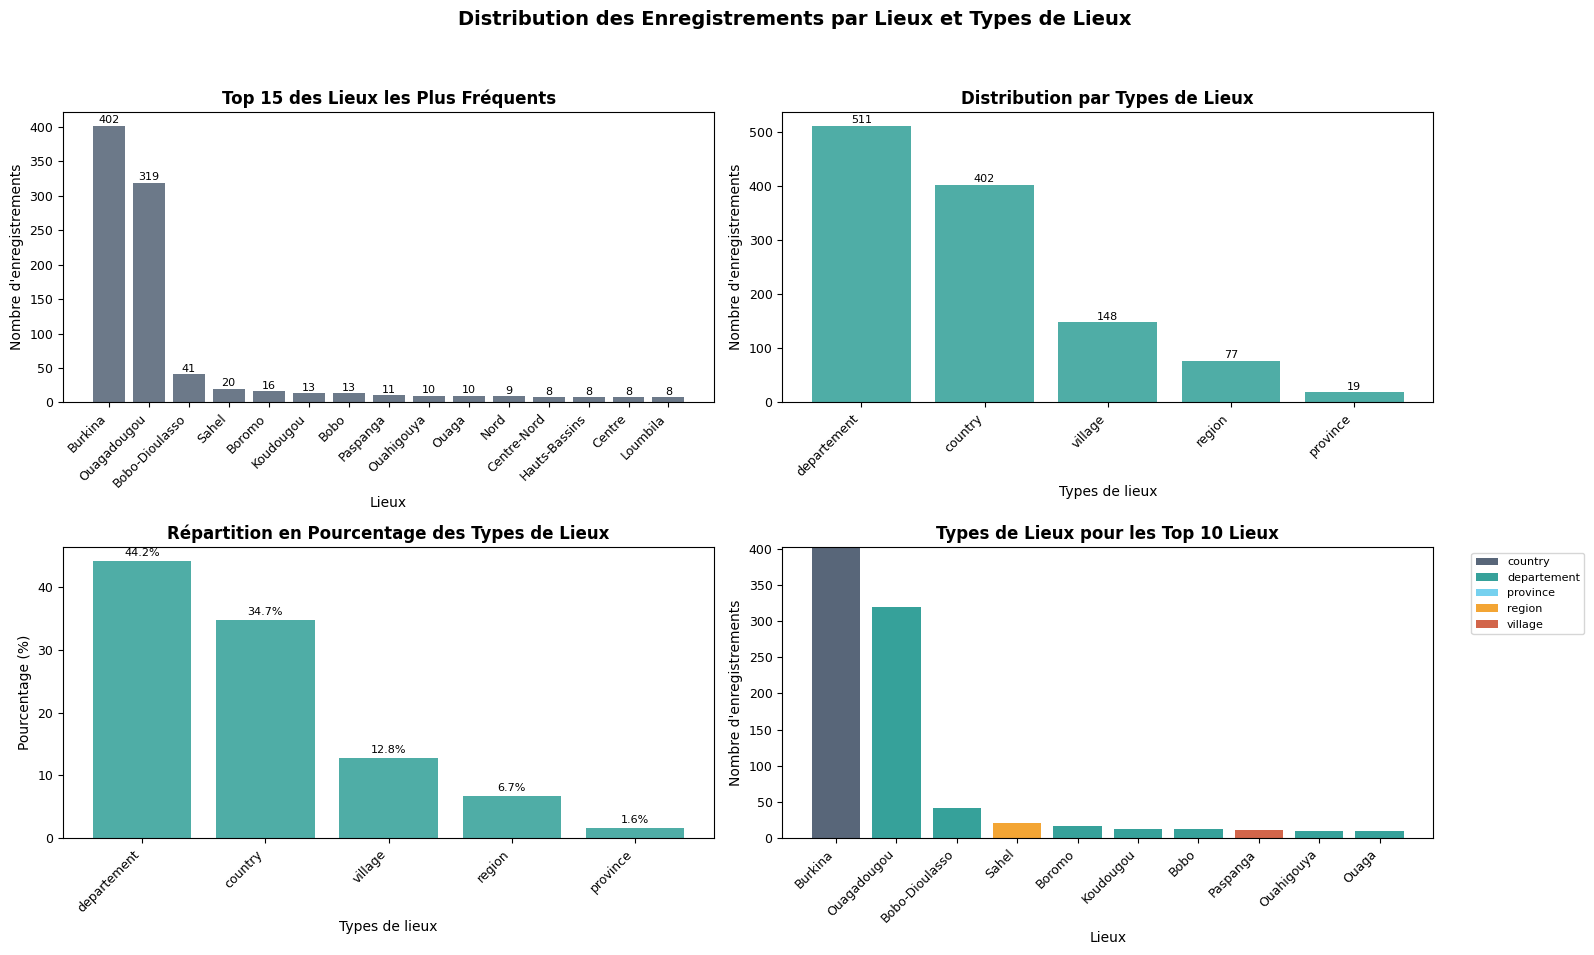


2. Analyse des termes et associations...


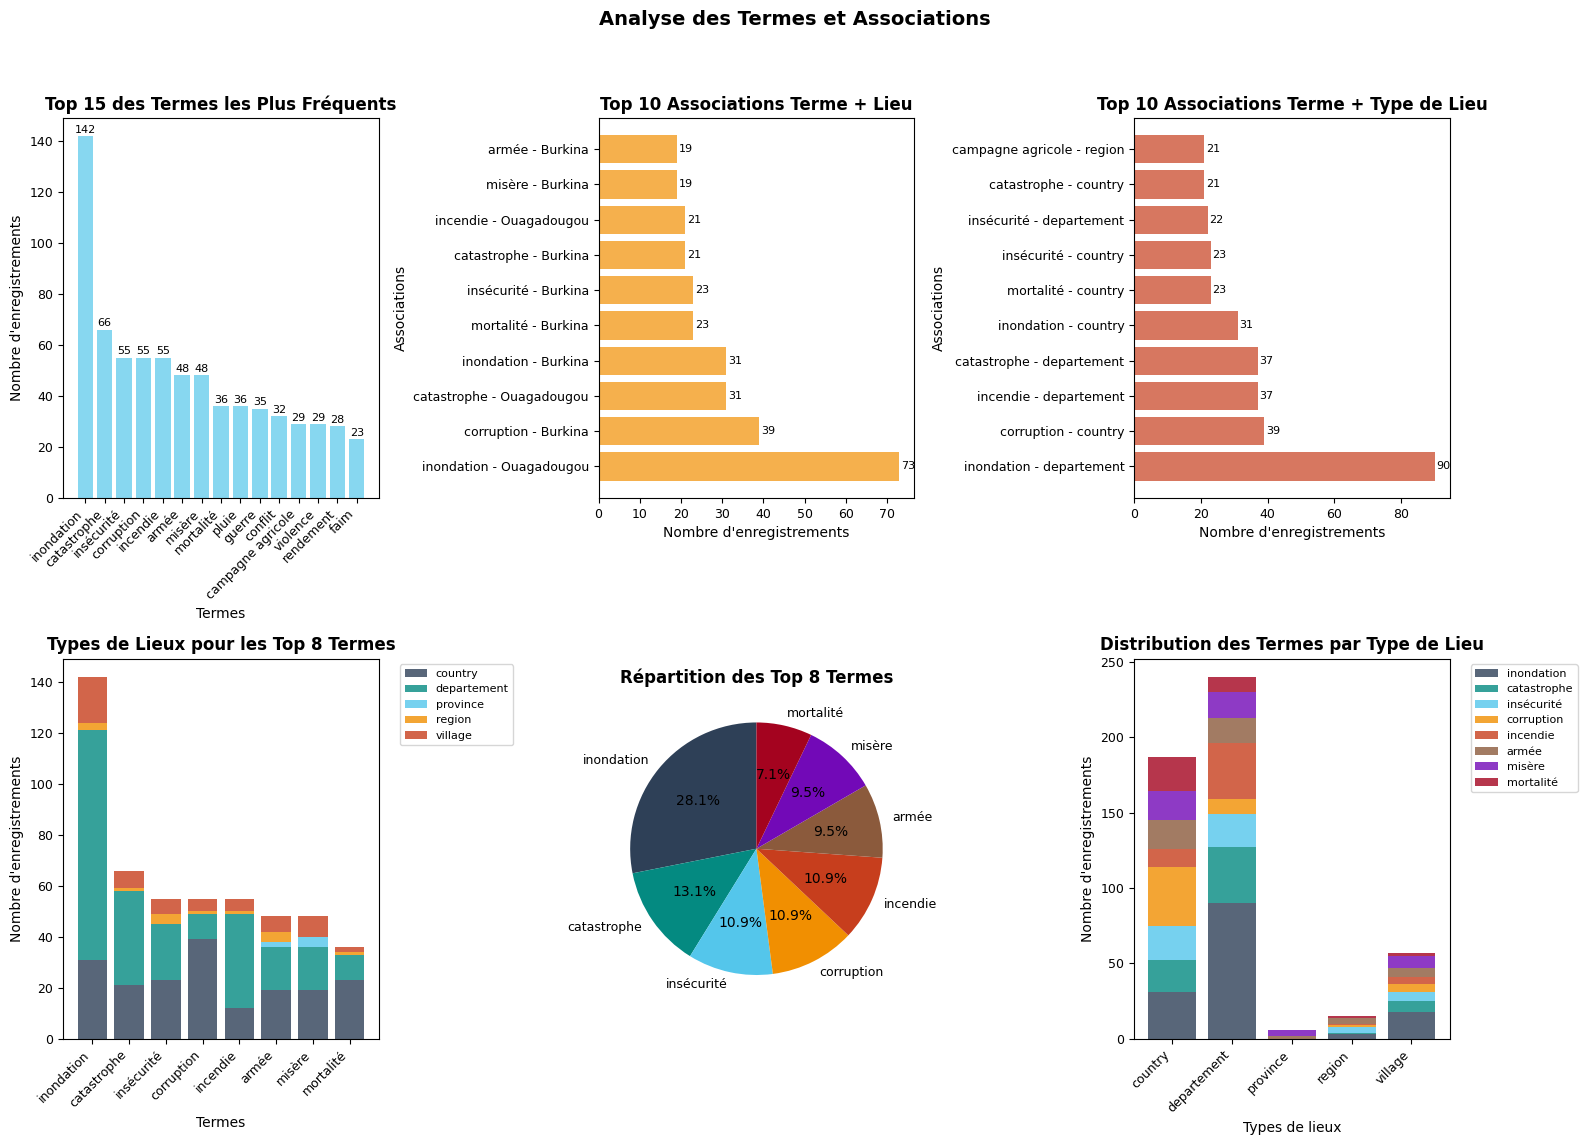


3. Analyse des distributions par label...


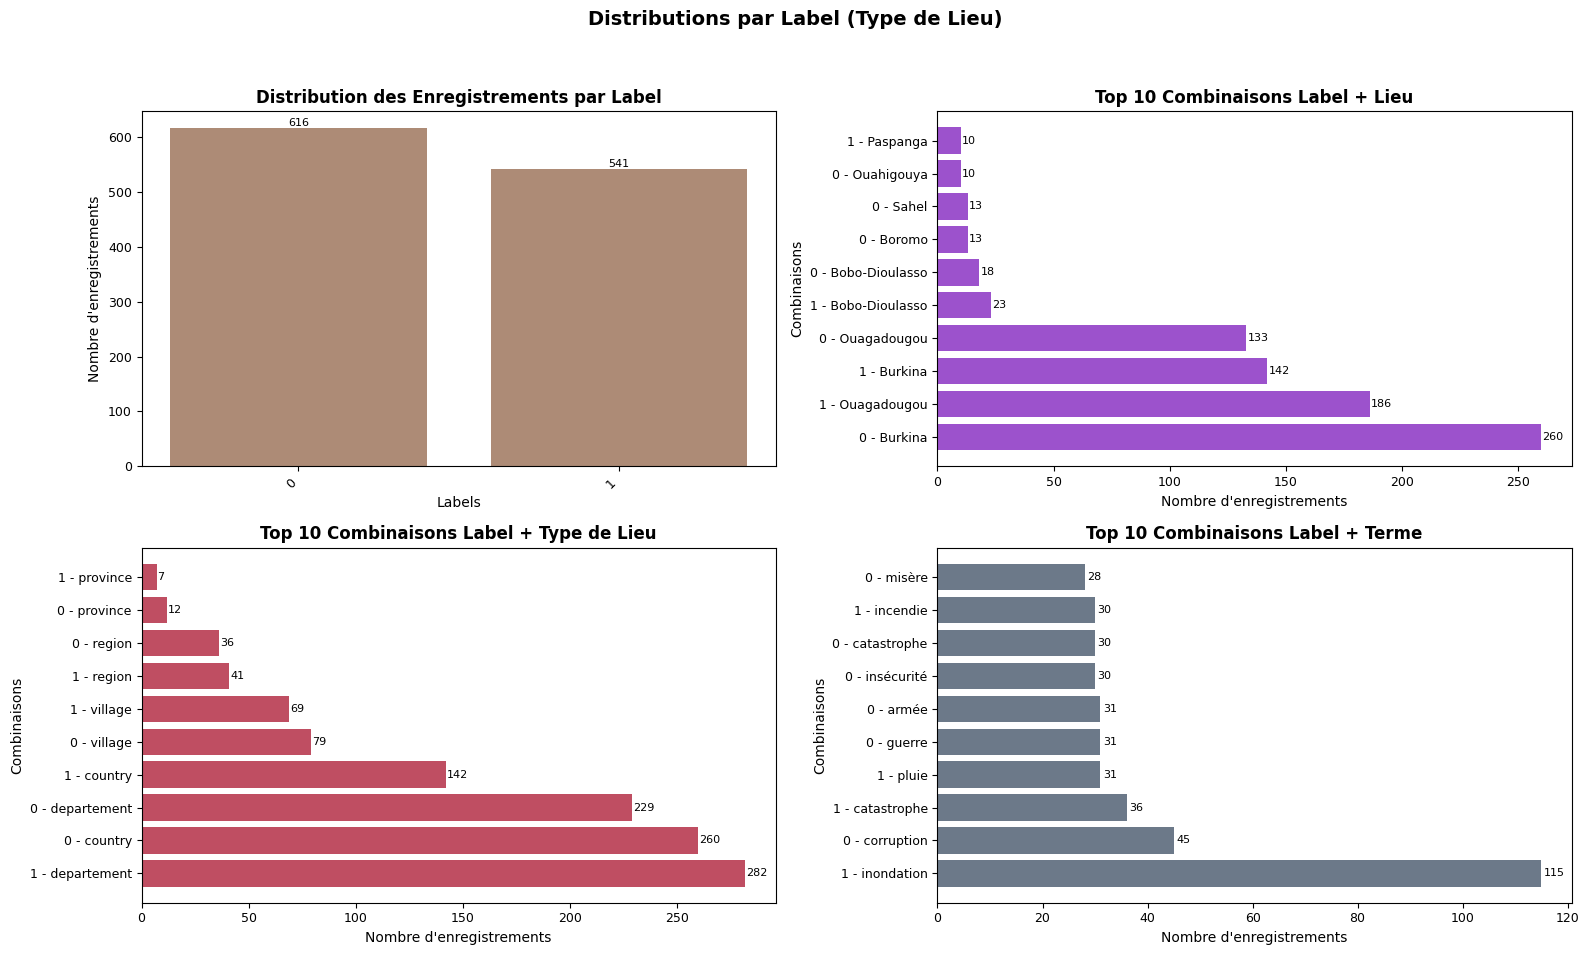


4. Analyse de la distribution par thème...


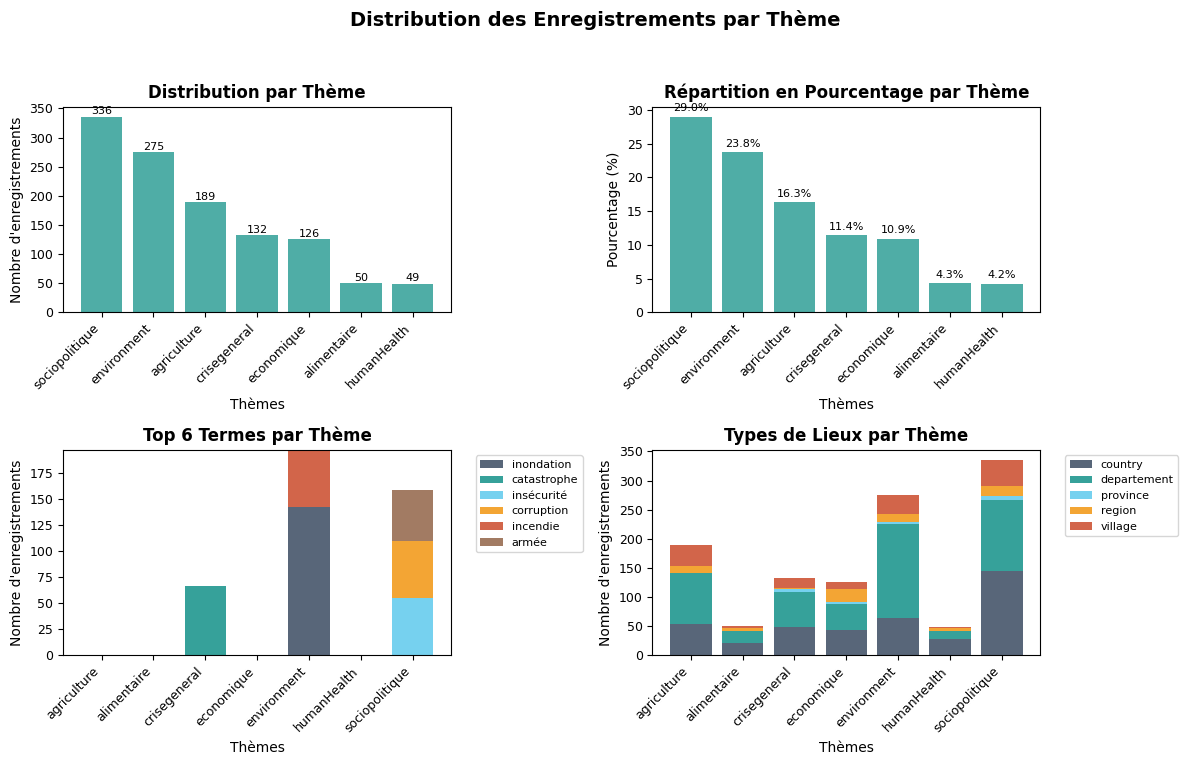


RÉSUMÉ STATISTIQUE COMPLET

📊 STATISTIQUES GÉNÉRALES:
   • Nombre total d'enregistrements: 1,157
   • Nombre de lieux uniques: 137
   • Nombre de types de lieux: 5
   • Nombre de termes uniques: 113
   • Nombre de thèmes: 7
   • Nombre de concepts: 40

🏆 TOP ÉLÉMENTS:
   • Lieu le plus fréquent: Burkina (402 occurrences)
   • Type de lieu dominant: departement (511 occurrences)
   • Terme le plus fréquent: inondation (142 occurrences)
   • Thème dominant: sociopolitique (336 occurrences)
   • Concept dominant: inondation (151 occurrences)

🔗 ASSOCIATIONS LES PLUS FRÉQUENTES:
   • Terme + Lieu: inondation - Ouagadougou (73 occurrences)
   • Terme + Type: inondation - departement (90 occurrences)
   • Label + Lieu: 0 - Burkina (260 occurrences)


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast
from matplotlib.patches import Rectangle

# Configuration globale pour des graphiques élégants et sobres
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

# Couleurs sobres et élégantes
colors_palette = ['#2E4057', '#048A81', '#54C6EB', '#F18F01', '#C73E1D', '#8B5A3C', '#7209B7', '#A4031F']

def extract_location_info(location_str):
    """Fonction robuste pour extraire les informations de localisation"""
    try:
        if pd.isna(location_str) or location_str == '':
            return None, None
        # Tentative avec ast.literal_eval
        try:
            location_dict = ast.literal_eval(location_str)
            return location_dict.get('text', ''), location_dict.get('label', '')
        except:
            pass
        # Tentative avec json
        try:
            import json
            json_str = str(location_str).replace("'", '"')
            location_dict = json.loads(json_str)
            return location_dict.get('text', ''), location_dict.get('label', '')
        except:
            pass
        # Parsing manuel
        import re
        text_match = re.search(r"'text':\s*'([^']*)'", str(location_str))
        label_match = re.search(r"'label':\s*'([^']*)'", str(location_str))
        if text_match and label_match:
            return text_match.group(1), label_match.group(1)
        return None, None
    except Exception as e:
        print(f"Erreur lors du parsing de: {str(location_str)[:50]}... -> {e}")
        return None, None

def create_figure_with_title(title, figsize=(12, 8)):
    """Fonction utilitaire pour créer une figure avec un titre principal"""
    fig = plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    return fig

# DIAGNOSTIC PRÉLIMINAIRE DES DONNÉES
print("=== DIAGNOSTIC DE LA STRUCTURE DES DONNÉES ===")
print(f"Nombre total d'enregistrements: {len(df_preprocessed)}")
print(f"Colonnes disponibles: {list(df_preprocessed.columns)}")

print("\n--- Échantillon de la colonne 'location' ---")
sample_locations = df_preprocessed['location'].head(3)
for i, loc in enumerate(sample_locations):
    print(f"Exemple {i+1}: {loc}")
    print(f"Type: {type(loc)}")
    print(f"Longueur: {len(str(loc)) if loc is not None else 'N/A'}")
    print("---")

print("=== ANALYSE STATISTIQUE COMPLÈTE DU DATAFRAME ===\n")

# Extraction des informations de localisation
print("Extraction des informations de localisation...")
location_data = df_preprocessed['location'].apply(extract_location_info)
df_preprocessed['lieu_text'] = location_data.apply(lambda x: x[0] if x[0] else 'Non spécifié')
df_preprocessed['lieu_label'] = location_data.apply(lambda x: x[1] if x[1] else 'Non spécifié')

print(f"\nAprès extraction:")
print(f"Lieux uniques extraits: {df_preprocessed['lieu_text'].nunique()}")
print(f"Types de lieux uniques: {df_preprocessed['lieu_label'].nunique()}")
print(f"Pourcentage de 'Non spécifié' pour les lieux: {(df_preprocessed['lieu_text']=='Non spécifié').mean()*100:.1f}%")
print(f"Pourcentage de 'Non spécifié' pour les types: {(df_preprocessed['lieu_label']=='Non spécifié').mean()*100:.1f}%")

if (df_preprocessed['lieu_text']=='Non spécifié').mean() > 0.9:
    print("\n⚠️ ATTENTION: Plus de 90% des données sont 'Non spécifié'")
    for i in range(min(3, len(df_preprocessed))):
        print(f"Ligne {i}: location = {df_preprocessed.iloc[i]['location']}")
        print(f"         → Résultat extraction: {extract_location_info(df_preprocessed.iloc[i]['location'])}")
        print("---")

# ========== 1. DISTRIBUTION DES LIEUX ET TYPES DE LIEUX ==========
print("\n1. Analyse de la distribution des lieux...")
fig = create_figure_with_title("Distribution des Enregistrements par Lieux et Types de Lieux", (16, 10))

# Top 15 lieux
plt.subplot(2, 2, 1)
lieu_counts = df_preprocessed['lieu_text'].value_counts().head(15)
bars1 = plt.bar(range(len(lieu_counts)), lieu_counts.values, color=colors_palette[0], alpha=0.7)
plt.title('Top 15 des Lieux les Plus Fréquents', fontweight='bold')
plt.xlabel('Lieux')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(lieu_counts)), lieu_counts.index, rotation=45, ha='right')
for i, bar in enumerate(bars1):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, str(lieu_counts.values[i]), ha='center', va='bottom', fontsize=8)

# Distribution par types de lieux
plt.subplot(2, 2, 2)
label_counts = df_preprocessed['lieu_label'].value_counts()
bars2 = plt.bar(range(len(label_counts)), label_counts.values, color=colors_palette[1], alpha=0.7)
plt.title('Distribution par Types de Lieux', fontweight='bold')
plt.xlabel('Types de lieux')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(label_counts)), label_counts.index, rotation=45, ha='right')
for i, bar in enumerate(bars2):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, str(label_counts.values[i]), ha='center', va='bottom', fontsize=8)

# Répartition en pourcentage des types de lieux (bar chart)
plt.subplot(2, 2, 3)
perc_label = label_counts / label_counts.sum() * 100
bars3 = plt.bar(range(len(perc_label)), perc_label.values, color=colors_palette[1], alpha=0.7)
plt.title('Répartition en Pourcentage des Types de Lieux', fontweight='bold')
plt.xlabel('Types de lieux')
plt.ylabel('Pourcentage (%)')
plt.xticks(range(len(perc_label)), perc_label.index, rotation=45, ha='right')
for i, bar in enumerate(bars3):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, f"{perc_label.values[i]:.1f}%", ha='center', va='bottom', fontsize=8)

# Stacked bar pour Top 10 lieux vs types de lieux
plt.subplot(2, 2, 4)
top_lieux = df_preprocessed['lieu_text'].value_counts().head(10).index
ct1 = pd.crosstab(df_preprocessed['lieu_text'], df_preprocessed['lieu_label']).loc[top_lieux]
bottom = np.zeros(len(ct1))
for i, lbl in enumerate(ct1.columns):
    plt.bar(range(len(ct1)), ct1[lbl], bottom=bottom, label=lbl, color=colors_palette[i % len(colors_palette)], alpha=0.8)
    bottom += ct1[lbl]
plt.title('Types de Lieux pour les Top 10 Lieux', fontweight='bold')
plt.xlabel('Lieux')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(ct1)), ct1.index, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ========== 2. ANALYSE DES TERMES ET ASSOCIATIONS ==========
print("\n2. Analyse des termes et associations...")
fig = create_figure_with_title("Analyse des Termes et Associations", (16, 12))

# Top 15 termes
plt.subplot(2, 3, 1)
term_counts = df_preprocessed['term'].value_counts().head(15)
bars4 = plt.bar(range(len(term_counts)), term_counts.values, color=colors_palette[2], alpha=0.7)
plt.title('Top 15 des Termes les Plus Fréquents', fontweight='bold')
plt.xlabel('Termes')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(term_counts)), term_counts.index, rotation=45, ha='right')
for i, bar in enumerate(bars4):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, str(term_counts.values[i]), ha='center', va='bottom', fontsize=8)

# Top 10 associations terme + lieu
plt.subplot(2, 3, 2)
df_preprocessed['term_lieu'] = df_preprocessed['term'] + ' - ' + df_preprocessed['lieu_text']
term_lieu_counts = df_preprocessed['term_lieu'].value_counts().head(10)
bars5 = plt.barh(range(len(term_lieu_counts)), term_lieu_counts.values, color=colors_palette[3], alpha=0.7)
plt.title('Top 10 Associations Terme + Lieu', fontweight='bold')
plt.xlabel("Nombre d'enregistrements")
plt.ylabel('Associations')
plt.yticks(range(len(term_lieu_counts)), [x[:30] + '...' if len(x)>30 else x for x in term_lieu_counts.index])
for i, bar in enumerate(bars5):
    plt.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2, str(term_lieu_counts.values[i]), ha='left', va='center', fontsize=8)

# Top 10 associations terme + type de lieu
plt.subplot(2, 3, 3)
df_preprocessed['term_label'] = df_preprocessed['term'] + ' - ' + df_preprocessed['lieu_label']
term_label_counts = df_preprocessed['term_label'].value_counts().head(10)
bars6 = plt.barh(range(len(term_label_counts)), term_label_counts.values, color=colors_palette[4], alpha=0.7)
plt.title('Top 10 Associations Terme + Type de Lieu', fontweight='bold')
plt.xlabel("Nombre d'enregistrements")
plt.ylabel('Associations')
plt.yticks(range(len(term_label_counts)), term_label_counts.index)
for i, bar in enumerate(bars6):
    plt.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2, str(term_label_counts.values[i]), ha='left', va='center', fontsize=8)

# Stacked bar pour Top 8 termes vs types de lieux
plt.subplot(2, 3, 4)
top_terms = df_preprocessed['term'].value_counts().head(8).index
ct2 = pd.crosstab(df_preprocessed['term'], df_preprocessed['lieu_label']).loc[top_terms]
bottom = np.zeros(len(ct2))
for i, lbl in enumerate(ct2.columns):
    plt.bar(range(len(ct2)), ct2[lbl], bottom=bottom, label=lbl, color=colors_palette[i % len(colors_palette)], alpha=0.8)
    bottom += ct2[lbl]
plt.title('Types de Lieux pour les Top 8 Termes', fontweight='bold')
plt.xlabel('Termes')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(ct2)), ct2.index, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)

# Répartition des Top 8 termes (pie)
plt.subplot(2, 3, 5)
top_terms_pie = term_counts.head(8)
plt.pie(top_terms_pie.values, labels=top_terms_pie.index, autopct='%1.1f%%', colors=colors_palette[:len(top_terms_pie)], startangle=90)
plt.title('Répartition des Top 8 Termes', fontweight='bold')

# Distribution des termes par type de lieu (stacked bar)
plt.subplot(2, 3, 6)
pivot_term_label = ct2.T
bottom = np.zeros(len(pivot_term_label))
for i, term in enumerate(pivot_term_label.columns):
    plt.bar(pivot_term_label.index, pivot_term_label[term], bottom=bottom, label=term, color=colors_palette[i % len(colors_palette)], alpha=0.8)
    bottom += pivot_term_label[term]
plt.title('Distribution des Termes par Type de Lieu', fontweight='bold')
plt.xlabel('Types de lieux')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ========== 3. DISTRIBUTIONS PAR LABEL ==========
print("\n3. Analyse des distributions par label...")
fig = create_figure_with_title("Distributions par Label (Type de Lieu)", (16, 10))

# Distribution simple par label
plt.subplot(2, 2, 1)
label_dist = df_preprocessed['label'].value_counts()
bars7 = plt.bar(range(len(label_dist)), label_dist.values, color=colors_palette[5], alpha=0.7)
plt.title('Distribution des Enregistrements par Label', fontweight='bold')
plt.xlabel('Labels')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(label_dist)), label_dist.index, rotation=45, ha='right')
for i, bar in enumerate(bars7):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, str(label_dist.values[i]), ha='center', va='bottom', fontsize=8)

# Top 10 combinaisons Label + Lieu
plt.subplot(2, 2, 2)
df_preprocessed['label_lieu'] = df_preprocessed['label'].astype(str) + ' - ' + df_preprocessed['lieu_text']
label_lieu_counts = df_preprocessed['label_lieu'].value_counts().head(10)
bars8 = plt.barh(range(len(label_lieu_counts)), label_lieu_counts.values, color=colors_palette[6], alpha=0.7)
plt.title('Top 10 Combinaisons Label + Lieu', fontweight='bold')
plt.xlabel("Nombre d'enregistrements")
plt.ylabel('Combinaisons')
plt.yticks(range(len(label_lieu_counts)), [x[:25] + '...' if len(x)>25 else x for x in label_lieu_counts.index])
for i, bar in enumerate(bars8):
    plt.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2, str(label_lieu_counts.values[i]), ha='left', va='center', fontsize=8)

# Top 10 combinaisons Label + Type de Lieu
plt.subplot(2, 2, 3)
df_preprocessed['label_type_lieu'] = df_preprocessed['label'].astype(str) + ' - ' + df_preprocessed['lieu_label']
label_type_counts = df_preprocessed['label_type_lieu'].value_counts().head(10)
bars9 = plt.barh(range(len(label_type_counts)), label_type_counts.values, color=colors_palette[7], alpha=0.7)
plt.title('Top 10 Combinaisons Label + Type de Lieu', fontweight='bold')
plt.xlabel("Nombre d'enregistrements")
plt.ylabel('Combinaisons')
plt.yticks(range(len(label_type_counts)), label_type_counts.index)
for i, bar in enumerate(bars9):
    plt.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2, str(label_type_counts.values[i]), ha='left', va='center', fontsize=8)

# Top 10 combinaisons Label + Terme
plt.subplot(2, 2, 4)
df_preprocessed['label_term'] = df_preprocessed['label'].astype(str) + ' - ' + df_preprocessed['term']
label_term_counts = df_preprocessed['label_term'].value_counts().head(10)
bars10 = plt.barh(range(len(label_term_counts)), label_term_counts.values, color=colors_palette[0], alpha=0.7)
plt.title('Top 10 Combinaisons Label + Terme', fontweight='bold')
plt.xlabel("Nombre d'enregistrements")
plt.ylabel('Combinaisons')
plt.yticks(range(len(label_term_counts)), [x[:30] + '...' if len(x)>30 else x for x in label_term_counts.index])
for i, bar in enumerate(bars10):
    plt.text(bar.get_width()+0.5, bar.get_y()+bar.get_height()/2, str(label_term_counts.values[i]), ha='left', va='center', fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ========== 4. DISTRIBUTION PAR THÈME ==========
print("\n4. Analyse de la distribution par thème...")
fig = create_figure_with_title("Distribution des Enregistrements par Thème", (12, 8))

# Distribution simple par thème
plt.subplot(2, 2, 1)
theme_counts = df_preprocessed['theme'].value_counts()
bars11 = plt.bar(range(len(theme_counts)), theme_counts.values, color=colors_palette[1], alpha=0.7)
plt.title('Distribution par Thème', fontweight='bold')
plt.xlabel('Thèmes')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(theme_counts)), theme_counts.index, rotation=45, ha='right')
for i, bar in enumerate(bars11):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, str(theme_counts.values[i]), ha='center', va='bottom', fontsize=8)

# Répartition en pourcentage par thème (bar chart)
plt.subplot(2, 2, 2)
perc_theme = theme_counts / theme_counts.sum() * 100
bars12 = plt.bar(range(len(perc_theme)), perc_theme.values, color=colors_palette[1], alpha=0.7)
plt.title('Répartition en Pourcentage par Thème', fontweight='bold')
plt.xlabel('Thèmes')
plt.ylabel('Pourcentage (%)')
plt.xticks(range(len(perc_theme)), perc_theme.index, rotation=45, ha='right')
for i, bar in enumerate(bars12):
    plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5, f"{perc_theme.values[i]:.1f}%", ha='center', va='bottom', fontsize=8)

# Stacked bar: Thème vs Top 6 termes
plt.subplot(2, 2, 3)
top_terms_theme = df_preprocessed['term'].value_counts().head(6).index
ct3 = pd.crosstab(df_preprocessed['theme'], df_preprocessed['term'])[top_terms_theme]
bottom = np.zeros(len(ct3))
for i, term in enumerate(ct3.columns):
    plt.bar(range(len(ct3)), ct3[term], bottom=bottom, label=term, color=colors_palette[i % len(colors_palette)], alpha=0.8)
    bottom += ct3[term]
plt.title('Top 6 Termes par Thème', fontweight='bold')
plt.xlabel('Thèmes')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(ct3)), ct3.index, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)

# Stacked bar: Thème vs Types de lieux
plt.subplot(2, 2, 4)
ct4 = pd.crosstab(df_preprocessed['theme'], df_preprocessed['lieu_label'])
bottom = np.zeros(len(ct4))
for i, lbl in enumerate(ct4.columns):
    plt.bar(range(len(ct4)), ct4[lbl], bottom=bottom, label=lbl, color=colors_palette[i % len(colors_palette)], alpha=0.8)
    bottom += ct4[lbl]
plt.title('Types de Lieux par Thème', fontweight='bold')
plt.xlabel('Thèmes')
plt.ylabel("Nombre d'enregistrements")
plt.xticks(range(len(ct4)), ct4.index, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize=8)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



# ========== RÉSUMÉ STATISTIQUE ==========
print("\n" + "="*50)
print("RÉSUMÉ STATISTIQUE COMPLET")
print("="*50)

print(f"\n📊 STATISTIQUES GÉNÉRALES:")
print(f"   • Nombre total d'enregistrements: {len(df_preprocessed):,}")
print(f"   • Nombre de lieux uniques: {df_preprocessed['lieu_text'].nunique()}")
print(f"   • Nombre de types de lieux: {df_preprocessed['lieu_label'].nunique()}")
print(f"   • Nombre de termes uniques: {df_preprocessed['term'].nunique()}")
print(f"   • Nombre de thèmes: {df_preprocessed['theme'].nunique()}")
print(f"   • Nombre de concepts: {df_preprocessed['concept'].nunique()}")

print("\n🏆 TOP ÉLÉMENTS:")
print(f"   • Lieu le plus fréquent: {df_preprocessed['lieu_text'].value_counts().index[0]} ({df_preprocessed['lieu_text'].value_counts().iloc[0]} occurrences)")
print(f"   • Type de lieu dominant: {df_preprocessed['lieu_label'].value_counts().index[0]} ({df_preprocessed['lieu_label'].value_counts().iloc[0]} occurrences)")
print(f"   • Terme le plus fréquent: {df_preprocessed['term'].value_counts().index[0]} ({df_preprocessed['term'].value_counts().iloc[0]} occurrences)")
print(f"   • Thème dominant: {df_preprocessed['theme'].value_counts().index[0]} ({df_preprocessed['theme'].value_counts().iloc[0]} occurrences)")
print(f"   • Concept dominant: {df_preprocessed['concept'].value_counts().index[0]} ({df_preprocessed['concept'].value_counts().iloc[0]} occurrences)")

print("\n🔗 ASSOCIATIONS LES PLUS FRÉQUENTES:")
print(f"   • Terme + Lieu: {term_lieu_counts.index[0]} ({term_lieu_counts.iloc[0]} occurrences)")
print(f"   • Terme + Type: {term_label_counts.index[0]} ({term_label_counts.iloc[0]} occurrences)")
print(f"   • Label + Lieu: {label_lieu_counts.index[0]} ({label_lieu_counts.iloc[0]} occurrences)")


